# Differential Evolution Flash Algorithm in Clapeyron.jl

In this notebook, we demonstrate a multicomponent flash algorithm for use with `Clapeyron.jl`, which utilizes the excellent differential evolution black box optimization algorithms in `BlackBoxOptim.jl`. 

In particular, we solve the non-reactive, isothermal, isobaric multicomponent flash problem for a system with $\texttt{numspecies}$ components, which we hypothesize to be distributed between $\texttt{numphases}$ phases. We do this by finding the global minimum of the Gibbs Free Energy among all possible distributions of species within phases. At present, the user is required to specify $\texttt{numphases}$; if they are unsure of the number of phases, they may run the code with different numbers of phases and determine which gives smallest Gibbs Free Energy. They may also specify a larger number of phases than expected, and in this case the code should predict either (a) multiple phases with identical compositions, or (b) one or more phases with negligible number of moles.

The use of differential evolution algorithms to find global minima for phase equilbrium calculations has previously been demonstrated in the scientific literature. ([Figueira et al., 2009](https://doi.org/10.1016/S1570-7946(09)70397-9), [Srinivas,Rangaiah, 2007](https://doi.org/10.1016/j.compchemeng.2006.07.015)) It is likely that this approach is less efficient than specialized codes (c.f. Michelson and Mollerup's *Thermodynamic models : fundamentals & computational aspects*) but it is conceptually simple and quite effective for simple problems.

We begin by calling relevant packages.

In [1]:
using Clapeyron
using BlackBoxOptim
using Plots
using StatsPlots
using Plots
using LaTeXStrings
using TernaryPlots

#Matlab Colour Scheme
MColor = ["#0072BD", "#D95319", "#EDB120", "#7E2F8E", "#77AC30", "#4DBEEE"];


6-element Vector{String}:
 "#0072BD"
 "#D95319"
 "#EDB120"
 "#7E2F8E"
 "#77AC30"
 "#4DBEEE"

## Check Equilibrium via Fugacity Calculation
For conveniece, we define a function which calculates the fugacities of all species in all phases, which should be equal at equilibrium, and calculates an error term quantifying the relative difference between them.

In [3]:
"""
    SpeciesFugacityCheck(model, T, p, x)
Function to check if fugacities are equal for all species between phases.

#Inputs: 
# - T, Temperature in Kelvin
# - p, Pressure in Pascals
# - xij, mole fraction of species j in phase i.
"""
function SpeciesFugacityCheck(model::EoSModel, T, p, x)
    
    numphases, numspecies = size(x)
    Fugacities = zeros(numphases, numspecies)
    for i = 1:numphases
        Fugacities[i,:] = fugacity_coefficient(model, p, T, x[i,:]) .* x[i,:] .* p
    end
    
    RelErrorSpecies = zeros(numspecies)
    for j = 1:numspecies
        RelErrorSpecies[j] = (sum(abs(Fugacities[1,j] - Fugacities[i,j])/Fugacities[1,j] for i in 2:numphases))/(numphases-1)
    end
    
    normRelError = sum(abs.(RelErrorSpecies)) / numspecies
    
    return (normRelError, RelErrorSpecies, Fugacities)
    
end

SpeciesFugacityCheck (generic function with 1 method)

# Mixture of ethane and hexane
## PCSAFT

In [4]:
system1PCSAFT = PCSAFT(["ethane","hexane"])
T = 30 + 273.15
p = 1e5
n = [0.5, 0.5]
method = DETPFlash(numphases = 2)

(x_1PC, nvals_1PC, G_1PC) = tp_flash(system1PCSAFT, p, T, n, method)

println("We get two phases with ethane mole fractions of ", x_1PC[1,1], " and ", x_1PC[2,1],
    " and hexane mole fractions of ", x_1PC[1,2], " and ", x_1PC[2,2],
    ", respectively. 
    Clearly there is mostly-pure liquid hexane phase, with a mixed gas above it.")


We get two phases with ethane mole fractions of 0.7490703108633583 and 0.02519645180933611 and hexane mole fractions of 0.25092968913664165 and 0.9748035481906638, respectively. 
    Clearly there is mostly-pure liquid hexane phase, with a mixed gas above it.


We may calculate the fugacities of species in these phases, and see if they are equal.

In [5]:
(normRelError_1PC, RelErrorSpecies_1PC, Fugacities_1PC) = SpeciesFugacityCheck(system1PCSAFT, T, p, x_1PC)

println("The average fugacity difference is ", normRelError_1PC, ". The ethane fugacties are ", Fugacities_1PC[1,1], 
    "Pa and ", Fugacities_1PC[2,1], "Pa, while the hexane fugacities are ", Fugacities_1PC[1,2], 
    "Pa and ", Fugacities_1PC[2,2], "Pa, in phase 1 and two, respectively.")

The average fugacity difference is 8.049257364824922e-8. The ethane fugacties are 74466.24154795945Pa and 74466.24910127698Pa, while the hexane fugacities are 24110.882053829915Pa and 24110.88061796969Pa, in phase 1 and two, respectively.


## Peng Robinson

In [6]:
system1PR = PR(["ethane","hexane"])
T = 30 + 273.15
p = 1e5
n = [0.5, 0.5]
method = DETPFlash() #by default, numphases = 2

(x_1PR, nvals_1PR, G1PR) = tp_flash(system1PR, p, T, n, method)

println("We get two phases with ethane mole fractions of ", x_1PR[1,1], " and ", x_1PR[2,1],
    " and hexane mole fractions of ", x_1PR[1,2], " and ", x_1PR[2,2],
    ", respectively. 
    Clearly there is mostly-pure liquid hexane phase, with a mixed gas above it.")


We get two phases with ethane mole fractions of 0.7486070938072128 and 0.02311738443041518 and hexane mole fractions of 0.25139290619278715 and 0.9768826155695848, respectively. 
    Clearly there is mostly-pure liquid hexane phase, with a mixed gas above it.


We may calculate the fugacities of species in these phases, and see if they are equal.

In [7]:
(normRelError_1PR, RelErrorSpecies_1PR, Fugacities_1PR) = SpeciesFugacityCheck(system1PR, T, p, x_1PR)

println("The average fugacity difference is ", normRelError_1PR, ". The ethane fugacties are ", Fugacities_1PR[1,1], 
    "Pa and ", Fugacities_1PR[2,1], "Pa, while the hexane fugacities are ", Fugacities_1PR[1,2], 
    "Pa and ", Fugacities_1PR[2,2], "Pa, in phase 1 and two, respectively.")

The average fugacity difference is 2.7010645693118354e-7. The ethane fugacties are 74367.16971884137Pa and 74367.19764842823Pa, while the hexane fugacities are 24067.545758219647Pa and 24067.549720929434Pa, in phase 1 and two, respectively.


In this case, both Peng Robinson and PCSAFT give quite similar predictions. Let's now test SAFT-$\gamma$-MIE:

### SAFT-$\gamma$-MIE

In [8]:
system1Gamma = SAFTgammaMie(["ethane","hexane"])
T = 30 + 273.15
p = 1e5
n = [0.5, 0.5]
method = DETPFlash()

(x_1G, nvals_1G, G_1G) = tp_flash(system1Gamma, p, T, n, method)

println("We get two phases with ethane mole fractions of ", x_1G[1,1], " and ", x_1G[2,1],
    " and hexane mole fractions of ", x_1G[1,2], " and ", x_1G[2,2],
    ", respectively. 
    Clearly there is mostly-pure liquid hexane phase, with a mixed gas above it.")


We get two phases with ethane mole fractions of 0.024451965869850285 and 0.7437626198881842 and hexane mole fractions of 0.9755480341301497 and 0.25623738011181585, respectively. 
    Clearly there is mostly-pure liquid hexane phase, with a mixed gas above it.


In [9]:
(normRelError_1G, RelErrorSpecies_1G, Fugacities_1G) = SpeciesFugacityCheck(system1Gamma, T, p, x_1G)

println("The average fugacity difference is ", normRelError_1G, ". The ethane fugacties are ", Fugacities_1G[1,1], 
    "Pa and ", Fugacities_1G[2,1], "Pa, while the hexane fugacities are ", Fugacities_1G[1,2], 
    "Pa and ", Fugacities_1G[2,2], "Pa, in phase 1 and two, respectively.")

The average fugacity difference is 4.661729426576147e-7. The ethane fugacties are 73988.09317443322Pa and 73988.04009906345Pa, while the hexane fugacities are 24707.704613648064Pa and 24707.709925699175Pa, in phase 1 and two, respectively.


In [10]:
@time tp_flash(system1PCSAFT, p, T, n, DETPFlash())
@time tp_flash(system1PR, p, T, n, DETPFlash())
@time tp_flash(system1Gamma, p, T, n, DETPFlash());

  0.686501 seconds (2.25 M allocations: 236.306 MiB, 10.89% gc time)
  0.089519 seconds (1.01 M allocations: 60.526 MiB)
  3.831194 seconds (3.19 M allocations: 1.175 GiB, 11.21% gc time)


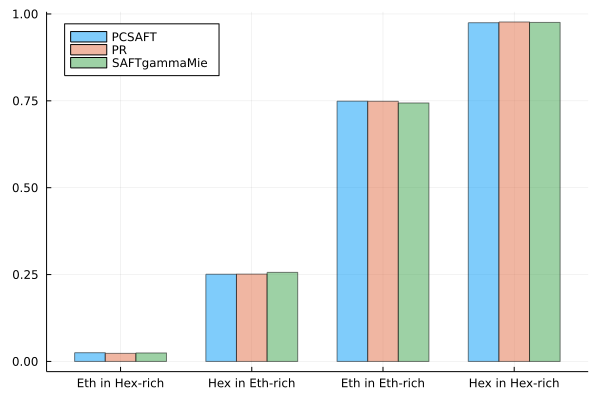

In [11]:
tempA = sort(reshape(x_1PC, 4))
tempB = sort(reshape(x_1PR, 4))
tempC = sort(reshape(x_1G, 4))
temp = [tempA  tempB  tempC]
groupedbar(temp, bar_position = :dodge, bar_width=0.7, alpha=0.5, 
    legend = :topleft, label = ["PCSAFT" "PR" "SAFTgammaMie"], 
    xticks = (1:4, ["Eth in Hex-rich", "Hex in Eth-rich", "Eth in Eth-rich", "Hex in Hex-rich"]))

The results are similar for all three, though the SAFT algorithms are more computationally demanding.


# Mixture of Ethane, Hexane and Water, PCSAFT

In [12]:
system2PCSAFT = PCSAFT(["ethane","hexane", "water"])
T = 30 + 273.15
p = 1e5
n = [0.34, 0.33, 0.33]
method = DETPFlash(numphases=3)

(x_2PC, nvals_2PC, G_2PC) = tp_flash(system2PCSAFT, p, T, n, method)

println("We have an ethane-rich phase, a water-rich phase, and a hexane-rich phase, with compositions 
    ", x_2PC[1,:], ", 
    ", x_2PC[2,:], ",  
    ", x_2PC[3,:])


We have an ethane-rich phase, a water-rich phase, and a hexane-rich phase, with compositions 
    [0.7058821246879092, 0.24971486419647107, 0.044403011115619666], 
    [0.02364754952057805, 0.9687802303886404, 0.007572220090781585],  
    [5.0102998104890766e-5, 2.0003050895598433e-5, 0.9999298939509995]


In [13]:
(normRelError_2PC, RelErrorSpecies_2PC, Fugacities_2PC) = SpeciesFugacityCheck(system2PCSAFT, T, p, x_2PC)

println("The relative error is, ", normRelError_2PC, " and the species fugacities are displayed")
Fugacities_2PC

The relative error is, 3.762884316852742e-6 and the species fugacities are displayed


3×3 Matrix{Float64}:
 70181.7  24001.5  4388.09
 70181.6  24001.5  4388.09
 70182.2  24001.8  4388.09

Note that we increased the maximum steps to 100,000 to ensure complete convergence.

## Mixture of Ethane, Hexane and Water, PR

Compare the result when using Peng Robinson:

In [14]:
system2PR = PR(["ethane","hexane", "water"])
T = 30 + 273.15
p = 1e5
n = [0.34, 0.33, 0.33]
method = DETPFlash(numphases=3,max_steps = 2e4)

(x_2PR, nvals_2PR, G_2PR) = tp_flash(system2PR, p, T, n, method)

println("We have an ethane-rich phase, a water-rich phase, and a hexane-rich phase, with compositions 
    ", x_2PR[1,:], ", 
    ", x_2PR[2,:], ",  
    ", x_2PR[3,:])


We have an ethane-rich phase, a water-rich phase, and a hexane-rich phase, with compositions 
    [0.7167117695661728, 0.24635911927640092, 0.03692911115742632], 
    [0.02200810396783344, 0.9571643863076773, 0.02082750972448929],  
    [8.923836745203797e-7, 1.99193006396525e-11, 0.9999991075964062]


The predicted mole fractions aren't too different. Notice, however, that the hexane concentration in water is *very* low. This will lead to errors in calculating the hexane fugacity in the water-rich phase:

In [15]:
(normRelError_2PR, RelErrorSpecies_2PR, Fugacities_2PR) = SpeciesFugacityCheck(system2PR, T, p, x_2PR)

println("The relative error is, ", normRelError_2PR, " and the species fugacities are displayed")
Fugacities_2PR

The relative error is, 0.12324539723148746 and the species fugacities are displayed


3×3 Matrix{Float64}:
 71200.1  23584.3  3639.01
 71200.1  23584.3  3639.05
 71077.6  40983.2  3639.02

## Mixture of Ethane, Hexane and Water, SAFT-$\gamma$-MIE

Compare the result when using SAFT-$\gamma$-MIE:

In [16]:
system2Gamma = SAFTgammaMie(["ethane","hexane", "water"])
T = 30 + 273.15
p = 1e5
n = [0.34, 0.33, 0.33]
method = DETPFlash(numphases=3,max_steps = 2e4)

(x_2G, nvals_2G, G_2G) = tp_flash(system2Gamma, p, T, n, numphases, method)

println("We have an ethane-rich phase, a water-rich phase, and a hexane-rich phase, with compositions 
    ", x_2G[1,:], ", 
    ", x_2G[2,:], ",  
    ", x_2G[3,:])


We have an ethane-rich phase, a water-rich phase, and a hexane-rich phase, with compositions 
    [0.7008106734977442, 0.2563115398148199, 0.04287778668743583], 
    [2.7811328016804286e-5, 2.020412848338363e-6, 0.9999701682591349],  
    [0.023041418342880517, 0.9765634161197813, 0.0003951655373381743]


In [17]:
(normRelError_2G, RelErrorSpecies_2G, Fugacities_2G) = SpeciesFugacityCheck(system2Gamma, T, p, x_2G)

println("The relative error is, ", normRelError_2G, " and the species fugacities are displayed")
Fugacities_2G

The relative error is, 4.873844421250786e-5 and the species fugacities are displayed


3×3 Matrix{Float64}:
 69723.8  24733.6  4260.4
 69725.9  24739.9  4260.4
 69723.7  24733.6  4260.41

In [18]:
@time tp_flash(system2PCSAFT, p, T, n, DETPFlash(numphases=3,max_steps = 2e4))
@time tp_flash(system2PR, p, T, n, DETPFlash(numphases=3,max_steps = 2e4))
@time tp_flash(system2Gamma, p, T, n, DETPFlash(numphases=3,max_steps = 2e4));

  3.578832 seconds (14.61 M allocations: 2.061 GiB, 11.38% gc time, 0.17% compilation time)
  0.300924 seconds (3.30 M allocations: 202.459 MiB, 10.53% gc time)
 18.393722 seconds (15.91 M allocations: 4.843 GiB, 3.89% gc time)


The predicted mole fractions are very similar between the three methods (a ~70% ethane phase, a ~97% hexane phase, and a >99% water phase.)

# Mixture of CO2 and Water

We now calculate the mole fractions of CO2 in water and water in CO2.
## PCSAFT

In [19]:
system3PCSAFT = PCSAFT(["water", "carbon dioxide"])
T = 25 + 273.15
p = 101.3e5
n = [1.0, 1.0]
method = DETPFlash()

(x_3PC, nvals_3PC, G_3PC) = tp_flash(system3PCSAFT, p, T, n, method)

x_3PC


2×2 Matrix{Float64}:
 0.978716    0.0212839
 0.00248565  0.997514

In [20]:
(normRelError_3PC, RelErrorSpecies_3PC, Fugacities_3PC) = SpeciesFugacityCheck(system3PCSAFT, T, p, x_3PC)

println("The relative error is, ", normRelError_3PC, " and the species fugacities are displayed")
Fugacities_3PC

The relative error is, 9.822943393912485e-7 and the species fugacities are displayed


2×2 Matrix{Float64}:
 3506.44  4.72546e6
 3506.44  4.72546e6

## Peng-Robinson

In [21]:
system3PR = PR(["water", "carbon dioxide"])
T = 25 + 273.15
p = 101.3e5
n = [1.0, 1.0]
method = DETPFlash(max_steps = 2e4)

(x_3PR, nvals_3PR, G_3PR) = tp_flash(system3PR, p, T, n, method)

x_3PR


2×2 Matrix{Float64}:
 0.996172   0.00382776
 0.0112981  0.988702

In [22]:
(normRelError_3PR, RelErrorSpecies_3PR, Fugacities_3PR) = SpeciesFugacityCheck(system3PR, T, p, x_3PR)

println("The relative error is, ", normRelError_3PR, " and the species fugacities are displayed")
Fugacities_3PR

The relative error is, 1.0683585970640463e-6 and the species fugacities are displayed


2×2 Matrix{Float64}:
 2919.69  4.65567e6
 2919.69  4.65567e6

## SAFT-$\gamma$-MIE

In [23]:
system3Gamma = SAFTgammaMie(["water", "carbon dioxide"])
T = 25 + 273.15
p = 101.3e5
n = [1.0, 1.0]
method = DETPFlash(max_steps = 2e4)

(x_3Gamma, nvals_3Gamma, G_3Gamma) = tp_flash(system3Gamma, p, T, n, method)

x_3Gamma


2×2 Matrix{Float64}:
 0.974077    0.0259231
 0.00377853  0.996221

In [24]:
(normRelError_3Gamma, RelErrorSpecies_3Gamma, Fugacities_3Gamma) = SpeciesFugacityCheck(system3Gamma, T, p, x_3Gamma)

println("The relative error is, ", normRelError_3Gamma, " and the species fugacities are displayed")
Fugacities_3Gamma

The relative error is, 1.7903928306185937e-6 and the species fugacities are displayed


2×2 Matrix{Float64}:
 3358.9  4.90732e6
 3358.9  4.90731e6

Experimentally-measured compositions under these conditions ([King et al., 1992]( https://doi.org/10.1016/0896-8446(92)90021-B)) are:

|       | Water Rich Phase | CO2 Rich Phase |
|-------|------------------|----------------|
| Water | 97.49%           | 0.327%         |
| CO2   | 2.51%            | 99.673%        |
 
The predicted values are:

*PCSAFT*:

|       | Water Rich Phase | CO2 Rich Phase |
|-------|------------------|----------------|
| Water | 97.9%            | 0.24%          |
| CO2   | 2.1%             | 99.76%         |


*Peng-Robinson*:

|       | Water Rich Phase | CO2 Rich Phase |
|-------|------------------|----------------|
| Water | 99.62%           | 1.1%           |
| CO2   | 0.38%            | 98.9%          |

*SAFT-$\gamma$-MIE*:

|       | Water Rich Phase | CO2 Rich Phase |
|-------|------------------|----------------|
| Water | 97.41%           | 0.38%          |
| CO2   | 2.59%            | 99.62%         |


 
It is clear that the SAFT equations are more accurate here, while the default Peng-Robinson EOS just can't handle the inter-species interaction, and predicts quite nonsensical species compositions. However, SAFT-$\gamma$-MIE is quite slow, presumably because the large degree of association slows down convergence of the EOS:

In [25]:
@time tp_flash(system3PCSAFT, p, T, n, DETPFlash())
@time tp_flash(system3PR, p, T, n, DETPFlash())
@time tp_flash(system3Gamma, p, T, n, DETPFlash())

  1.172239 seconds (4.72 M allocations: 668.208 MiB, 12.59% gc time)
  0.074748 seconds (849.95 k allocations: 51.486 MiB)
292.256990 seconds (1.93 G allocations: 116.943 GiB, 6.80% gc time)


([0.003778540896258692 0.9962214591037413; 0.9740770146064364 0.025922985393563733], [0.0036923058959725938 0.9734853924130537; 0.9963076941040274 0.026514607586946348], -22802.3677447803)

# Ternary Mixture of Methanol, CO2 and Water 

## Comparison with Experiment
We calculate the solubility of CO2 in water-methanol mixtures, and compare the results with the data of [Xia et al., 2004)](https://doi.org/10.1021/je049803i).


In [26]:
storeCO2molality = zeros(3,3)
i = 0
for T = [313.75, 354.35, 395.0]
    i += 1
    j = 0
    for xmethanol = [0.1, 0.5, 0.9]
        j += 1
        
        system4Gamma = SAFTgammaMie(["water", "carbon dioxide", "methanol"])
        #T = 313.75
        p = 50e5
        n = [1-xmethanol, 1.0, xmethanol]
        numphases = 2

        (x_4Gamma, nvals_4Gamma, G_4Gamma) = tp_flash(system4Gamma, p, T, n, numphases, MaxSteps = 1e4)

        MW_Water = 0.018; MW_CO2 = 0.044; MW_Methanol = 0.032
        if x_4Gamma[1,2] < 0.5
            CO2molality = x_4Gamma[1,2] / (x_4Gamma[1,1]*MW_Water + x_4Gamma[1,3]*MW_Methanol)
        else
            CO2molality = x_4Gamma[2,2] / (x_4Gamma[2,1]*MW_Water + x_4Gamma[2,3]*MW_Methanol)
        end

        storeCO2molality[i,j] = CO2molality
    end
end


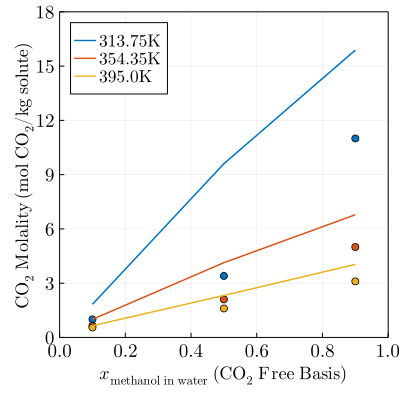

In [27]:
dataCO2molality = [1.0 3.4 11.0; 0.65 2.1 5.0; 0.55 1.6 3.1]

using Plots
using LaTeXStrings
MColor = ["#0072BD", "#D95319", "#EDB120", "#7E2F8E", "#77AC30", "#4DBEEE"]

scatter( [0.1, 0.5, 0.9],  dataCO2molality[1,:], color = MColor[1], label = "")
plot!(   [0.1, 0.5, 0.9], storeCO2molality[1,:], color = MColor[1], label = "313.75K", lw = 1.5)
scatter!([0.1, 0.5, 0.9],  dataCO2molality[2,:], color = MColor[2], label = "")
plot!(   [0.1, 0.5, 0.9], storeCO2molality[2,:], color = MColor[2], label = "354.35K", lw = 1.5)
scatter!([0.1, 0.5, 0.9],  dataCO2molality[3,:], color = MColor[3], label = "")
plot!(   [0.1, 0.5, 0.9], storeCO2molality[3,:], color = MColor[3], label = "395.0K", lw = 1.5,
    xlabel = L"$x_{\mathrm{methanol\ in\ water}}\ \mathrm{(CO_2 \ Free\ Basis)}$", 
    ylabel = L"$\mathrm{CO_2\ Molality\ (mol\ CO_2/kg\ solute)}$", 
    legend = :topleft,
    legendfontsize = 11,
    size = (400,400), 
    framestyle=:box, 
    tickfont = font(12, "serif-roman"), 
    fontfamily = "serif-roman", 
    guidefontsize = 12, 
    grid=true,
    ylims = (0, 18),
    xlims = (0,1))

SAFT-$\gamma$-MIE's predictions are OK, especially at higher temperatures. Note that 40°C, 50 bar is close to the critical point of CO2, and this may be responsible for the greater error under these conditions. 
## Ternary Phase Diagram

We now generate a ternary phase diagram for this system.

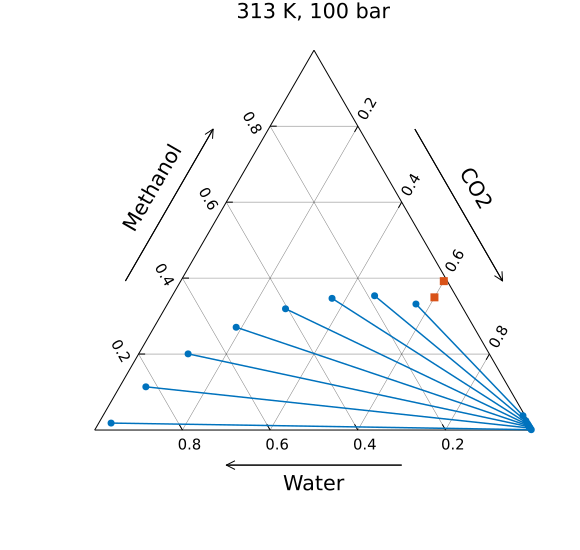

In [28]:
ternary_axes(
    title = "313 K, 100 bar",
    xguide="Water",
    yguide="CO2",
    zguide="Methanol",
)

for x = LinRange(0.02, 0.98, 10)
    system = SAFTgammaMie(["water", "carbon dioxide", "methanol"])
    T = 313.15
    p = 100e5
    n = [x*0.4,0.6,(1-x)*0.4]
    method = DETPFlash(numphases = 2, max_steps = 1e4)
    (x, nvals, G) = tp_flash(system, p, T, n, method)

    if abs(x[1,1] - x[2,1]) / x[2,1] < 1e-3
        #Single Phase
        BoundaryPoint = zeros(1,2)
        BoundaryPoint[1,:] = collect(tern2cart(x[1,:]))'
        p = scatter!(BoundaryPoint[:,1],BoundaryPoint[:,2], legend=false, color = MColor[2], markershape = :square, markerstrokewidth = 0.0)
    else
        BoundaryPoints = zeros(2,2)
        BoundaryPoints[1,:] = collect(tern2cart(x[1,:]))'
        BoundaryPoints[2,:] = collect(tern2cart(x[2,:]))'
        p = scatter!(BoundaryPoints[:,1],BoundaryPoints[:,2], legend=false, color = MColor[1], markerstrokewidth = 0.0)
        p = plot!(BoundaryPoints[:,1],BoundaryPoints[:,2], legend=false, color = MColor[1], lw = 1.5)
    end
end

p